# Part 2

## Setup

In [23]:
using Plots
using JuMP, HiGHS

include("src/utils.jl")
include("src/lshaped.jl")

multicut_lshaped (generic function with 1 method)

In [24]:
DATA_DIR = "data/"

"data/"

In [25]:
prices = vec(read_file(DATA_DIR * "belpex_price.txt"))
states = vec(read_file(DATA_DIR * "markov_support_4.txt"))
P_prob = read_file(DATA_DIR * "markov_weights_4.txt")

4×4 Matrix{Float64}:
 0.394106    0.524075   0.0807228  0.00109546
 0.107876    0.564185   0.311323   0.016616
 0.016616    0.311323   0.564185   0.107876
 0.00109546  0.0807228  0.524075   0.394106

## Questions

Before considering the full multistage stochastic programming problem, let us trans-
form the problem into multistage problem that can be equivalently formulated as a
two-stage stochastic programming problem. In doing so, assume that the price in
the first 𝐹 hours of the day is perfectly known and equal to the expected price. Then,
generate 𝐾 scenarios that describe the evolution of the price for the next 𝑇 − 𝐹 hours.
Take 𝐹 = 5 and 𝐾 = 10. The scenario tree for this formulation is shown in Figure 2.

In [26]:
F = 5
K = 10

10

In [27]:
prices_scenarios = []
prices_prob = []

for (ξ_path, P_path) in [sample_chain_idx(24 - F + 1, P_prob, states; initial_state = 1) for i in 1:K]
    
    prices_k = prices[F+1:end] .* exp.(ξ_path[2:end])
    push!(prices_scenarios, prices_k)
    push!(prices_prob, P_path[2])
end


prices_prob = prices_prob ./ sum(prices_prob)

println("Prices scenarios: ", prices_scenarios)
println("Prices probabilities: ", prices_prob)

Prices scenarios: Any[[44.95071176331347, 47.724352109796214, 32.859237765869416, 37.82665573838712, 33.007796060374616, 18.939951125215046, 16.434261329637994, 11.503982930746597, 6.824396653832727, 3.8903703373549834, 3.761068889831583, 29.330978271370864, 46.38732745924939, 46.288860484116704, 54.82729556582619, 63.74079323613833, 79.89321659575447, 70.02772907867289, 69.69385340942667], [52.71033986912707, 47.724352109796214, 32.859237765869416, 37.82665573838712, 38.288000134525085, 25.762277446352748, 19.063223695670718, 13.344256586969504, 7.916084415998857, 4.512706626263295, 4.410324368123191, 29.330978271370864, 46.38732745924939, 54.27948685483826, 54.82729556582619, 63.74079323613833, 79.89321659575447, 60.37037692955155, 60.08254523394772], [52.71033986912707, 55.35873999759745, 38.11567720846253, 37.82665573838712, 33.007796060374616, 22.209465028527735, 19.063223695670718, 13.344256586969504, 6.824396653832727, 3.3176586628198597, 3.761068889831583, 29.330978271370864, 4

### 1. Formulate the two-stage-equivalent multistage stochastic programming problem

Let us define stage one variables:
* $b_1 = (b_{1,1}, \dots, b_{1,F})$ where $b_{1t} =$ battery level at $t \leq F$
* $\eta_1 = (\eta_{1,1}, \dots, \eta_{1,F})$ (discharging)
* $\xi_1 = (\xi_{1,1}, \dots, \xi_{1,F})$ (charging)
* $P_1 = (P_{1,1}, \dots, P_{1,F})$ (price)

and the stage 2 variables :
* $b_{2,\omega} = (b_{1,F+1}(\omega), \dots, b_{1,T}(\omega))$ where $b_{1t} =$ battery level at $t > F$
* $\eta_{2,\omega} = (\eta_{1,F+1}(\omega), \dots, \eta_{1,T}(\omega))$ (discharging)
* $\xi_{2, \omega} = (\xi_{1,F+1}(\omega), \dots, \xi_{1,T}(\omega))$ (charging)
* $P_{2, \omega} = (P_{2,F+1}(\omega), \dots, P_{2,T}(\omega))$ (price)

Finally the problem reads:
$$
\begin{align*}
    \max& P_1 \cdot (0.9 \eta_1 - \frac{1}{0.9}\xi_1) + \mathbb{E}\bigg[P_{2, \omega}\cdot (0.9\eta_{2, \omega} - \frac{1}{0.9}\xi_{2,\omega})\bigg] \\
    \text{s.t.}~& A_1 b_1 + B_1 \eta_1 + C_1 \xi_1 = 0\\
    & A_1 b_{2, \omega} + B_1 \eta_{2, \omega} + C_1 \xi_{2, \omega} = 0,\quad \forall \omega \in \Omega\\
    &b_{2, F+1, \omega} = b_{1, F} - \eta_{2, F+1, \omega} + \xi_{2, F+1, \omega} \\
    &0\leq \eta_1 \leq 200, \quad 0\leq \eta_{2, \omega} \leq 200 \quad \forall \omega \in \Omega \\
    &0\leq \xi_1 \leq 200, \quad 0\leq \xi_{2, \omega} \leq 200 \quad \forall \omega \in \Omega \\
    & 0 \leq b_1 \leq 800, \quad 0 \leq b_{2, \omega} \leq 800,\quad \forall \omega \in \Omega \\
    & x_1, x_2, \eta_1, \eta_2, \xi_1, \xi_2 \geq 0

\end{align*}
$$

where $A_1, B_1, C_1$ are chosen accordingly.

### 2. Explain why this problem is equivalent to a two-stage stochastic program.


Given the scenario tree we can conclude that each branch is independent of the others meaning that although it involves mutiple stage, we can resume these into a single vector. Encapsulating the $F$ first desicion into a single vector, makes the problem a two-stage problem. 

### 3. Implement the L-Shaped and the multicut L-Shaped algorithm for solving this problem. For both algorithms, plot the evolution of the lower and upper bounds.

In [28]:
ret_l = lshaped(
    prices[1:F],
    prices_scenarios,
    prices_prob,
    2*1e5,
)

Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic lic

┌ Info: Adding Benders cut: 47.12858219523661 b1[6] - θ ≥ -44109.75728220655
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:126
┌ Info: Adding Benders cut: 34.658130660646805 b1[6] - θ ≥ -48195.10372063376
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:126
┌ Info: Adding Benders cut: 42.61441131819299 b1[6] - θ ≥ -45012.59145761528
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:126


(lb = Any[61635.37950442876, 64304.04487378136, 64500.864913858226, 64847.76261014275], ub = Any[217525.6222222222, 65206.87904919008, 65076.8827161689, 64847.76261014276], b1 = [0.0, 200.0, 400.0, 600.0, 400.0000000000015, 200.00000000000148], η1 = [0.0, 0.0, 0.0, 199.99999999999852, 200.0], ξ1 = [200.0, 200.0, 200.0, 0.0, 0.0], b2 = [[200.00000000000148, 200.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0], [200.00000000000148, 1.4779288903810084e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0], [200.00000000000148, 200.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0], [200.00000000000148, 1.4779288903810084e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 200.0, 0.0], [200.00000000000148, 1.4779288903810084e-12, 0.0, 200.0, 0.0, 0.

In [29]:
ret_mc = multicut_lshaped(
    prices[1:F],
    prices_scenarios,
    prices_prob,
    2*1e5
)

Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic license - for non-commercial use only - expires 2026-04-15
Set parameter Username
Set parameter LicenseID to value 2652777
Academic lic

┌ Info: Adding Benders cut for scenario 1: -42.95191689881659 b1[6] + θ[1] ≤ 45230.71354831731
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:203
┌ Info: Adding Benders cut for scenario 2: -47.43930588221436 b1[6] + θ[2] ≤ 40828.23175975838
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:203
┌ Info: Adding Benders cut for scenario 3: -49.82286599783771 b1[6] + θ[3] ≤ 42965.81519290184
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:203
┌ Info: Adding Benders cut for scenario 4: -47.43930588221436 b1[6] + θ[4] ≤ 45226.7681129527
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:203
┌ Info: Adding Benders cut for scenario 5: -55.028095383214925 b1[6] + θ[5] ≤ 49215.86387737951
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/lshaped.jl:203
┌ Info: Adding Benders cut for scenario 6: -47.43930588221436 b1[6] + θ[6] ≤ 40955.94354987627
└ @ Main /Users/theohanon/Desktop/Operational-Research/src/l

(lb = Any[61635.37950442876, 64304.04487378137, 64651.032867371585, 64847.76261014276], ub = Any[217525.6222222222, 65206.879049190095, 64925.450141510744, 64847.76261014276], b1 = [0.0, 200.0, 400.0, 600.0, 399.99999999999784, 199.99999999999784], η1 = [0.0, 0.0, 0.0, 200.00000000000216, 200.0], ξ1 = [200.0, 200.0, 200.0, 0.0, 0.0], b2 = [[199.99999999999784, 200.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0], [199.99999999999784, -2.1600499167107046e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0], [199.99999999999784, 200.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0], [199.99999999999784, -2.1600499167107046e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 200.0, 0.0], [199.99999999999784, -2.1600499167107046e-12, 0.0, 200.0, 

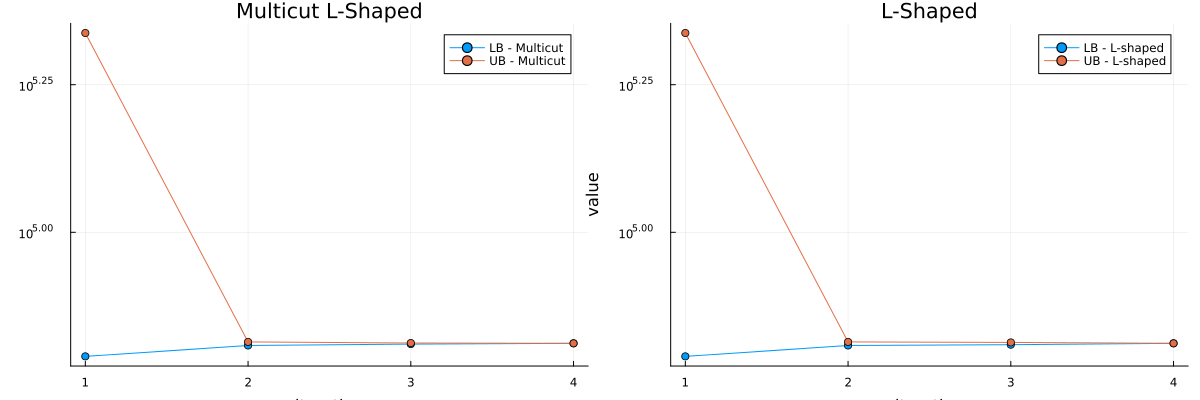

In [ ]:
p1 = plot(
    ret_mc.lb,
    label = "LB - Multicut",
    title = "Multicut L-Shaped",
    xlabel = "iteration",
    ylabel = "value",
    legend = :topright,
    xticks = 1:4,
    marker = :circle,
    # yscale = :log10,
)
plot!(
    p1,
    ret_mc.ub,
    label = "UB - Multicut",
    marker = :circle,
    # yscale = :log10,
)

p2 = plot(
    ret_l.lb,
    label = "LB - L-shaped",
    title = "L-Shaped",
    xlabel = "iteration",
    ylabel = "value",
    legend = :topright,
    xticks = 1:5,
    marker = :circle,
    # yscale = :log10,
)
plot!(
    p2,
    ret_l.ub,
    label = "UB - L-shaped",
    marker = :circle,
    # yscale = :log10,
)

plot(p1, p2, layout = (1,2), size = (1200, 400), legend = :topright,  yscale = :log10)

In [31]:
b1 = ret_mc.b1
b2_w = ret_mc.b2

10-element Vector{Vector{Float64}}:
 [199.99999999999784, 200.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0]
 [199.99999999999784, -2.1600499167107046e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0]
 [199.99999999999784, 200.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0]
 [199.99999999999784, -2.1600499167107046e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 200.0, 0.0]
 [199.99999999999784, -2.1600499167107046e-12, 0.0, 200.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0]
 [199.99999999999784, -2.1600499167107046e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 400.0, 600.0, 800.0, 800.0, 800.0, 800.0, 800.0, 600.0, 400.0, 200.0, 0.0]
 [199.99999999999784, -2.1600499167107046e-1

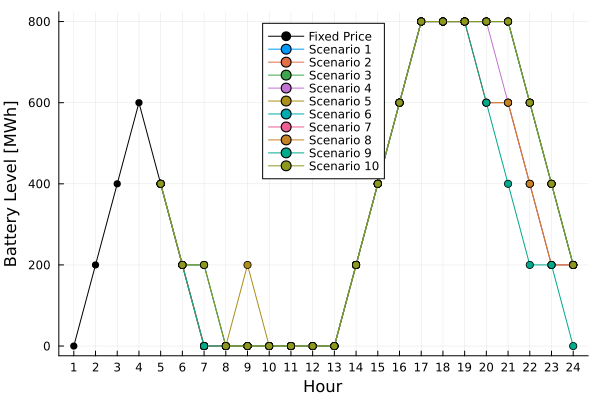

In [32]:
p1 = plot(
    1:F, 
    b1[1:F], 
    label="Fixed Price", 
    xlabel="Hour", 
    ylabel="Battery Level [MWh]", 
    color=:black,
    xticks = 1:24,
    marker= :circle,
    legend = :top,
)

for i in 1:K
    plot!(
        F:24,
        [b1[F];b2_w[i, :]...][1:24-F+1],
        xlabel="Hour",
        ylabel="Battery Level [MWh]",
        label = "Scenario $i",
        color = i,
        marker= :circle,)
end

display(p1)

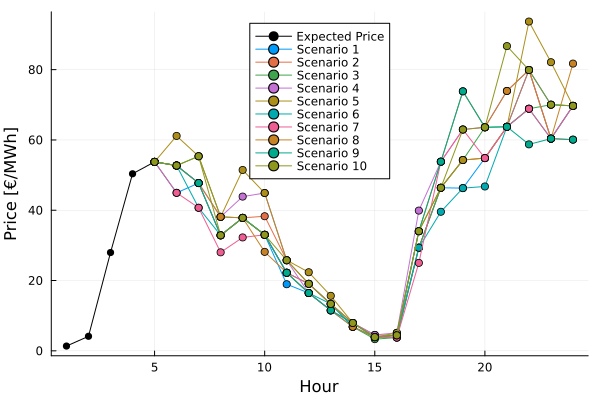

In [33]:
p2 = plot(
    1:F, 
    prices[1:F],
    label= "Expected Price",
    marker= :circle,
    color = :black
)

for i in 1:K
    plot!(
        F:24,
        [prices[F] ;prices_scenarios[i]],
        xlabel="Hour",
        ylabel="Price [€/MWh]",
        label = "Scenario $i",
        color = i,
        marker= :circle,
        legend = :top,)
end

display(p2)